In [8]:
import numpy as np
import matplotlib.pyplot as plt
import stochastics.merton_jump as merton_jump
from sklearn.metrics.pairwise import rbf_kernel
import filter.kalmanFilter as kalmanFilter
import math
import statistics


# Project made by Léa Beudin using Chat gpt  
# The project simulates an fx series using FX merton jump stochastic model and use the AI game algo DDA to rebalance between trading strategies
# Dynamic Difficulty Adjustment (DDA) can be adapted to trading as a mechanism
# to automatically adjust a trading strategy based on current market conditions or the performance of the strategy.  
# Todo Léa insert multiple asset 
# extend t insert portfolio rebalance trading strategy


itterations = 1000
# Simulated time series data (replace with your real data)
merton = merton_jump.FX_merton([1.2,0.0001,0.0015,0.05,0.00001,0.1])
market_data = merton.build_series(itterations)
market_data_filtered = kalmanFilter.kalman_filter(market_data,  0.001, 0.01)["filtered"]

strategies =  ["trend_following", "mean_reversion", "momentum", "contrarian"]



In [4]:
def evaluate_strategy_performance(market, strategy, lookback=5):
    """
    Evaluate strategy performance based on market data.
    
    :param market: The market price series (list or numpy array).
    :param strategy: The name of the strategy ('trend_following', 'mean_reversion', 'momentum', 'contrarian').
    :param lookback: Lookback period for momentum and contrarian strategies (default: 5).
    :return: Cumulative returns of the strategy as a numpy array.
    """
    market = np.array(market)
    returns = np.zeros(len(market) - 1)  # Returns will have one less value than market prices
    
    if strategy == "trend_following":
        # Buy if market goes up, sell if market goes down
        returns = np.sign(np.diff(market))
    
    elif strategy == "mean_reversion":
        # Sell if market goes up, buy if market goes down
        returns = -np.sign(np.diff(market))
    
    elif strategy == "momentum":
        # Buy if market has been going up over the lookback period
        momentum = market[lookback:] - market[:-lookback]
        signals = np.sign(momentum)
        returns = np.concatenate([np.zeros(lookback), signals[:-1]])  # Align with market length
    
    elif strategy == "contrarian":
        # Sell if market has been going up over the lookback period
        momentum = market[lookback:] - market[:-lookback]
        signals = -np.sign(momentum)
        returns = np.concatenate([np.zeros(lookback), signals[:-1]])  # Align with market length
    
    else:
        #todo extends 
        raise ValueError("Unknown strategy")
    
    # Calculate cumulative returns
    cumulative_returns = np.cumsum(returns)
    return cumulative_returns

def dynamic_adjustment_multi(strategies_returns, alpha=0.1):
    """
    Dynamically adjust weights for multiple strategies based on their recent performance.
    
    :param strategies_returns: A 2D numpy array where each column represents the returns of a strategy.
    :param alpha: Adjustment speed (learning rate).
    :return: Tuple of (adjusted_combined_returns, final_weights).
    """
    num_strategies = strategies_returns.shape[1]
    weights = np.ones(num_strategies) / num_strategies  # Start with equal weights
    combined_returns = []
    weights_tracker= []
    
    for returns in strategies_returns:

        # Calculate relative performance (normalize returns to avoid scaling issues)
        normalized_returns = returns - np.mean(returns)
        
        # Adjust weights for all strategies based on their performance
        for i in range(num_strategies):
            weights[i] += alpha * normalized_returns[i]
        
        min_weight = min(weights)
        if min_weight <0:
            weights = weights + abs(min_weight) # Ensure weights are non-negative
        weights /= np.sum(weights)  # Normalize to sum to 1

        # Combine returns based on weights using last steps adustment
        #chat gpt place the pnl calc after the weights update - if the weights once calculated are static then why not
        # but we also want to see whats happening if the forecast is great - see my version to see a  real case scenario
        combined_return = np.dot(weights, returns)
        combined_returns.append(combined_return.copy())
        weights_tracker.append(weights.copy())
    
    return np.array(combined_returns), weights, np.array(weights_tracker)

# Simulate multiple strategies
def simulate_strategy_performance2(market_data, strategies):
    """
    Simulate the returns of multiple strategies based on market data.
    :param market_data: The market data to simulate on.
    :param strategies: A list of strategy names.
    :return: A 2D numpy array where each column is a strategy's returns.
    """
    returns = []
    for strategy in strategies:
        strategy_returns = evaluate_strategy_performance(market_data, strategy)
        returns.append(strategy_returns)
    return np.array(returns).T  # Transpose to get strategies as columns



In [6]:
def plot_results(strategies, market_data, strategies_returns, adjusted_returns, weights_tracker, final_weights):
    
    # Plot results
    plt.figure(figsize=(14, 10))
    plt.subplot(5, 1, 1)
    plt.plot(market_data, label="Market Data", color="blue")
    plt.title("Simulated Market Data")
    plt.legend()

    for i, strategy in enumerate(strategies):
        plt.subplot(5, 1, 2)
        plt.plot(strategies_returns[:, i], label=f"{strategy.capitalize()} Returns")
    plt.title("Strategies Performance")
    plt.legend()

    plt.subplot(5, 1, 3)
    plt.plot(adjusted_returns, label="Combined Returns (DDA Adjusted)", color="purple")
    plt.title("Combined Returns with Dynamic Adjustment")
    plt.legend()

    for i, strategy in enumerate(strategies):
        plt.subplot(5, 1, 4)
        plt.plot(weights_tracker[:, i], label=f"{strategy.capitalize()} weight")
    plt.title("weights")
    plt.legend()


    plt.subplot(5, 1, 5)
    plt.bar(range(len(strategies)), final_weights, color="orange")
    plt.xticks(range(len(strategies)), strategies)
    plt.title("Final Strategy Weights")
    plt.ylabel("Weight")
    plt.xlabel("Strategies")

    plt.tight_layout()
    plt.show()

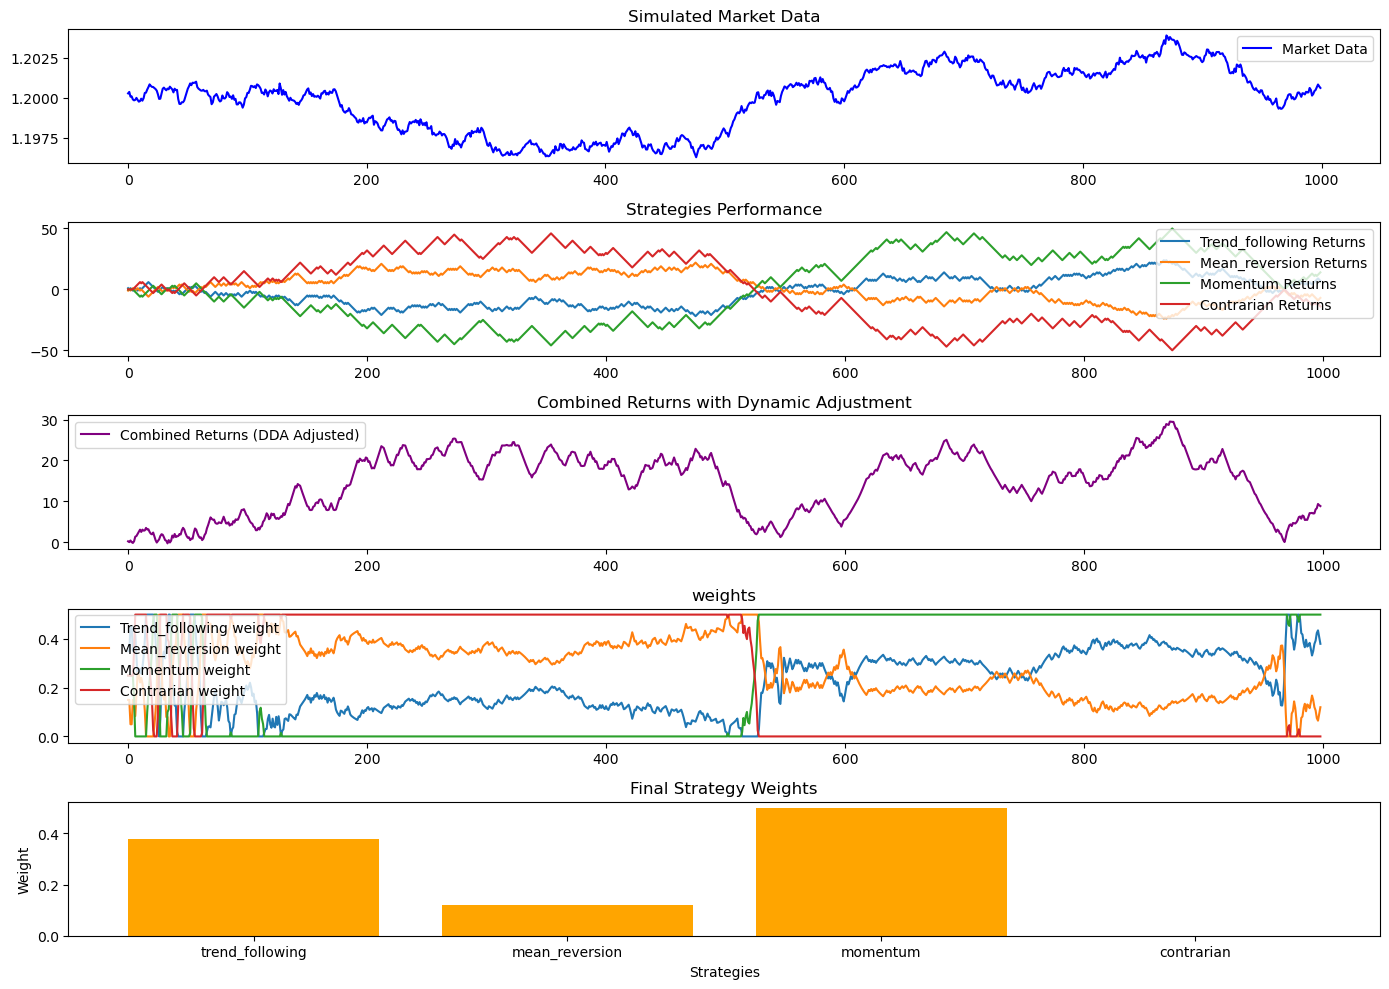

In [9]:

strategies_returns = simulate_strategy_performance2(market_data, strategies)

adjusted_returns, final_weights, weights_tracker = dynamic_adjustment_multi(strategies_returns)

plot_results(strategies, market_data, strategies_returns, adjusted_returns, weights_tracker, final_weights)

#chat gpt place the pnl calc after the weights update - if the weights once calculated are static then why not
# we then need to launcht the weight on a testing period and do a backtest but the weights stays statics


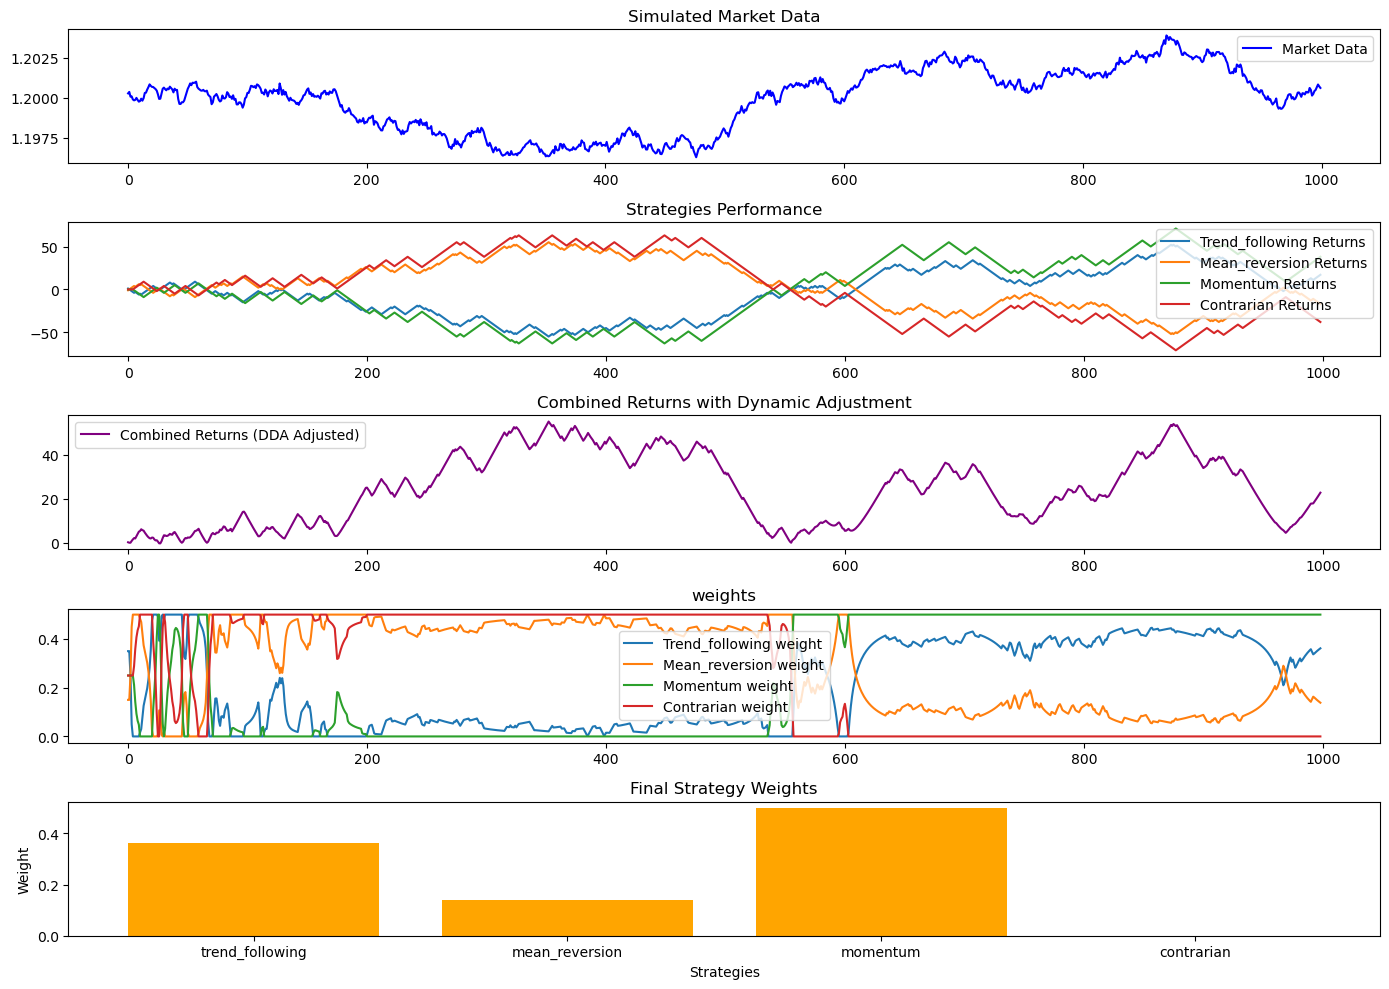

In [10]:
strategies_returns = simulate_strategy_performance2(market_data_filtered, strategies)

adjusted_returns, final_weights, weights_tracker = dynamic_adjustment_multi(strategies_returns)

plot_results(strategies, market_data, strategies_returns, adjusted_returns, weights_tracker, final_weights)

# using the kallman filter clearly improved the DDA decision although the trading strategies are simplistics



In [11]:
def DDA_intelligent(strategies_returns, alpha=0.1):
    """
    quite 
    """
    num_strategies = strategies_returns.shape[1]
    weights = np.ones(num_strategies) / num_strategies  # Start with equal weights
    combined_returns = []
    weights_tracker= []
    
    for returns in strategies_returns:
        # Combine returns based on weights calibrated the last step adustment
        combined_return = np.dot(weights, returns)
        combined_returns.append(combined_return.copy())
        weights_tracker.append(weights.copy())


        # Calculate relative performance (normalize returns to avoid scaling issues)
        normalized_returns = returns - np.mean(returns)
        
        # Adjust weights for all strategies based on their performance
        for i in range(num_strategies):
            weights[i] += alpha * normalized_returns[i]
        
        min_weight = min(weights)
        if min_weight <0:
            weights = weights + abs(min_weight) # Ensure weights are non-negative
        weights /= np.sum(weights)  # Normalize to sum to 1
    return np.array(combined_returns), weights, np.array(weights_tracker)



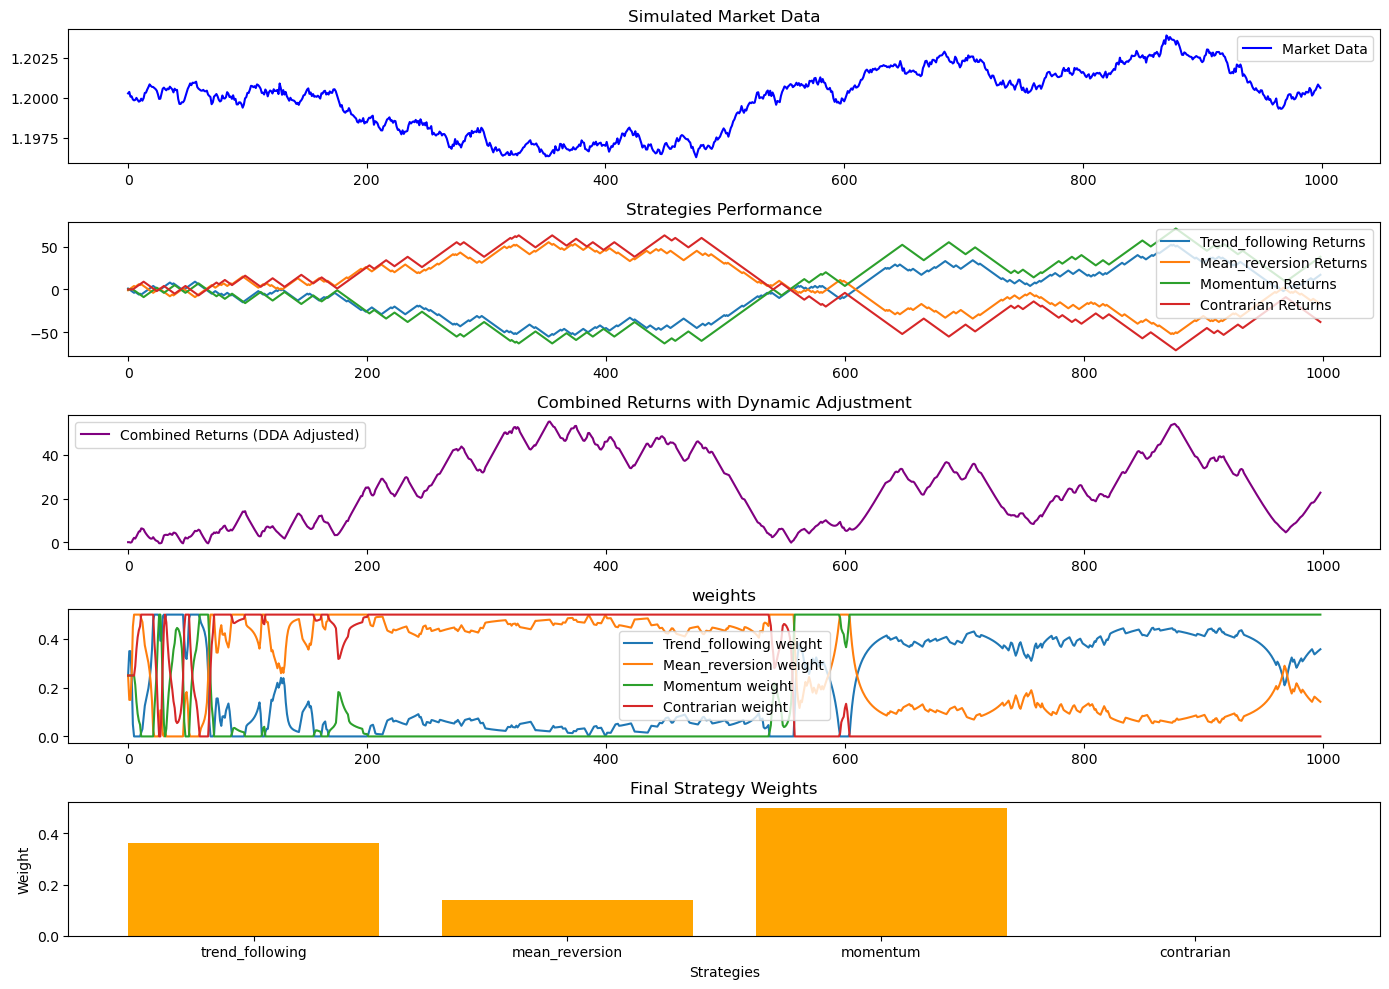

In [12]:
strategies_returns = simulate_strategy_performance2(market_data_filtered, strategies)
#strategies_returns = simulate_strategy_performance2(market_data, strategies) you can use this line - but the kallman filter is working better in this

adjusted_returns, final_weights, weights_tracker = DDA_intelligent(strategies_returns)

plot_results(strategies, market_data, strategies_returns, adjusted_returns, weights_tracker, final_weights)




Mean :54.33937338358287
Min :0.35172293618481437
Max :207.7881779183822


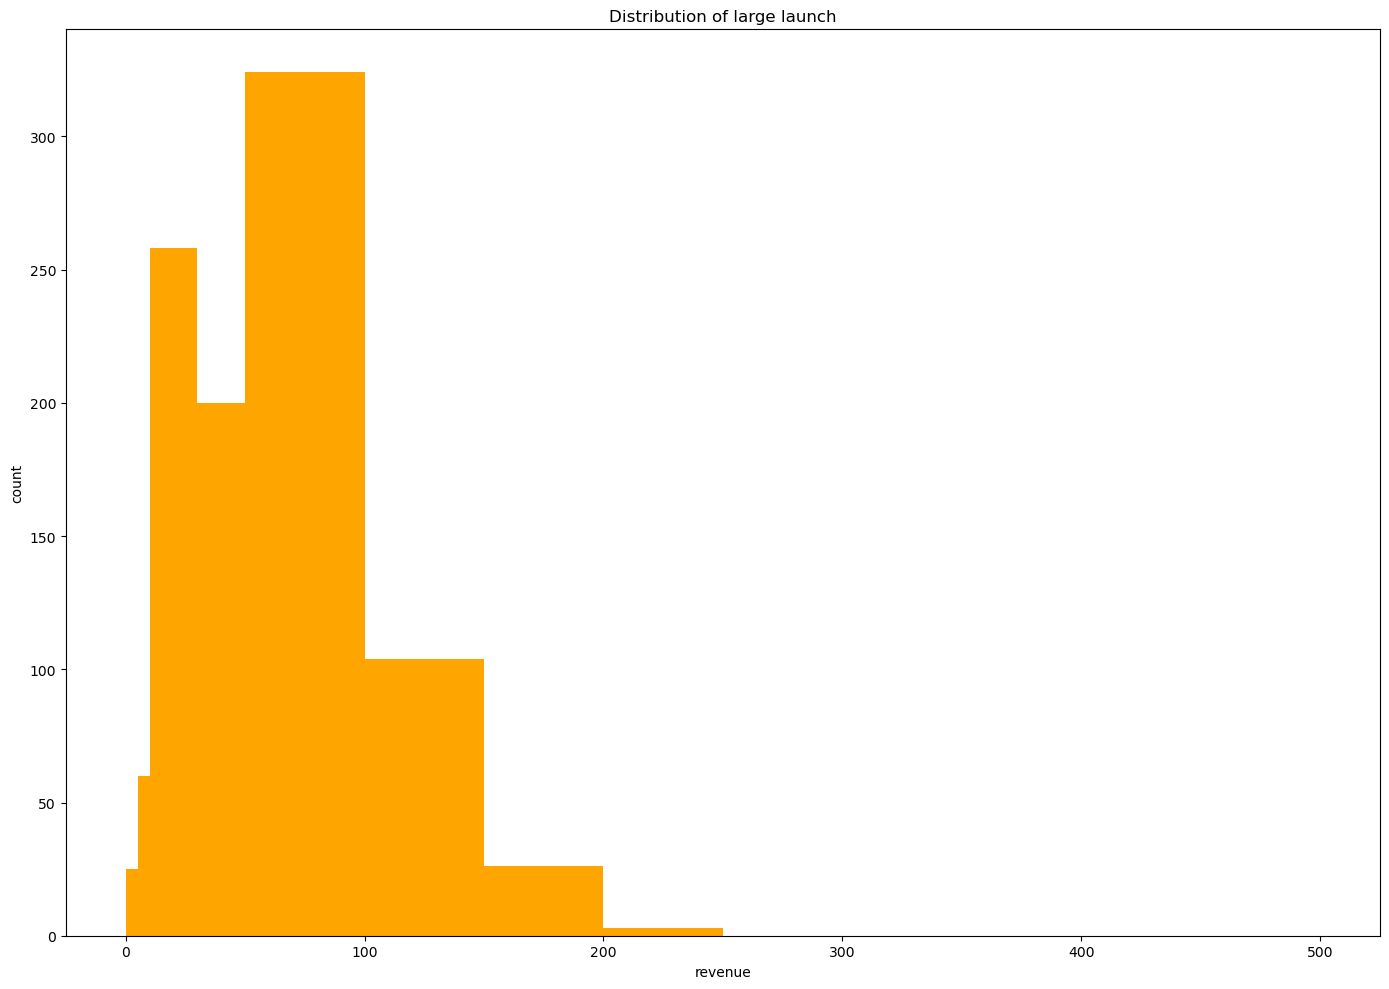

In [13]:
# step 2 we run over a large number of simulation
final_result = []
for i in range(1000):
    merton = merton_jump.FX_merton([1.2,0.0001,0.0015,0.05,0.0001,0.1])
    market_data = merton.build_series(itterations)
    market_data_filtered = kalmanFilter.kalman_filter(market_data,  0.001, 0.01)["filtered"]

    strategies_returns = simulate_strategy_performance2(market_data_filtered, strategies)

    adjusted_returns, final_weights, weights_tracker = DDA_intelligent(strategies_returns)
    final_result.append(adjusted_returns[-1])

# todo léa use the benchmark of the max return of the best strategy 
#todo léa insert time management
print("Mean :" + str( statistics.mean(final_result)))
print("Min :" + str(min(final_result)))
print("Max :" + str(max(final_result)))

 
plt.figure(figsize=(14, 10))
plt.hist(final_result, color="orange", bins =[0,5,10,30,50,100,150,200,250,500])
plt.title("Distribution of large launch")
plt.ylabel("count")
plt.xlabel("revenue")

plt.tight_layout()
plt.show()



In [ ]:
#Step 3 we do this over a portfolio 
